# <b><u>Insurance Customer Response Prediction<u></b>

In [39]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV




In [2]:
# importing dataset 
data = pd.read_csv("insurance data.csv")

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    381109 non-null  int64 
 1   Gender                381109 non-null  object
 2   Age                   381109 non-null  int64 
 3   Driving_License       381109 non-null  int64 
 4   Region_Code           381109 non-null  int64 
 5   Previously_Insured    381109 non-null  int64 
 6   Vehicle_Age           381109 non-null  object
 7   Vehicle_Damage        381109 non-null  object
 8   Annual_Premium        381109 non-null  int64 
 9   Policy_Sales_Channel  381109 non-null  int64 
 10  Vintage               381109 non-null  int64 
 11  Response              381109 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 34.9+ MB


- There are a total of <b>381109</b> entries.
- There are 12 columns with only <b>Gender, Vehicle_Age, Vehicle_Damage</b> are of object type and others are integer. 

In [5]:
data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

- Since there is no missing value therefore no imputation is needed.

## <b><u>Exploratory Data Analysis</u><b>

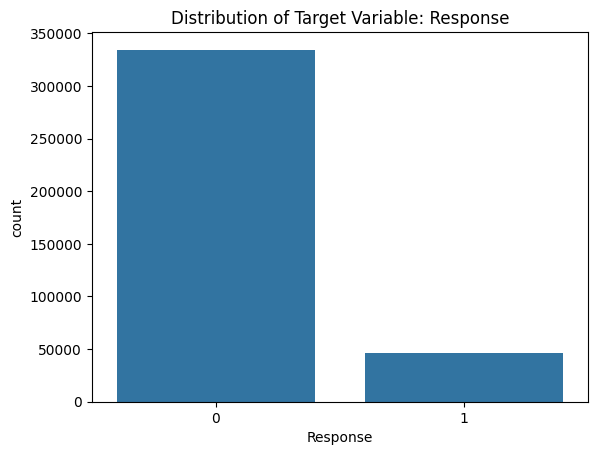

Response
0    87.743664
1    12.256336
Name: proportion, dtype: float64


In [6]:
# Target value distribution - telling how the response is distributed  
sns.countplot(x='Response', data=data)
plt.title('Distribution of Target Variable: Response')
plt.show()

print(data['Response'].value_counts(normalize=True)*100)

Interpretation:

<b>After seeing the above result we can clearly see :<b>
- The dataset is highly imbalanced.
- Almost 88% do not response positively.
- and 12% responded positvely.
- Therefore we need to use metrics like(Precision, Recall F1-score, ROC-AUC, Confusion Matrix).

### Univariate Analysis

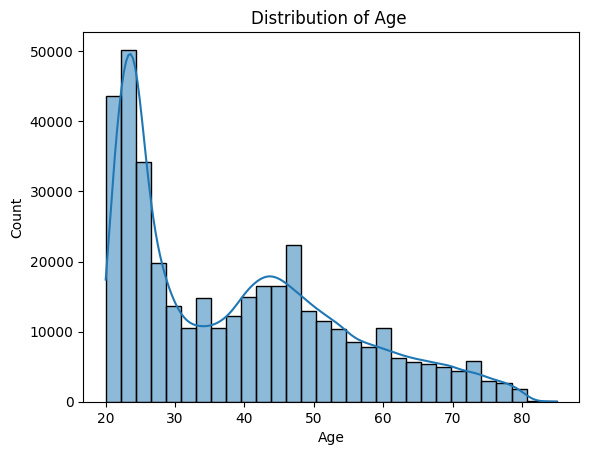

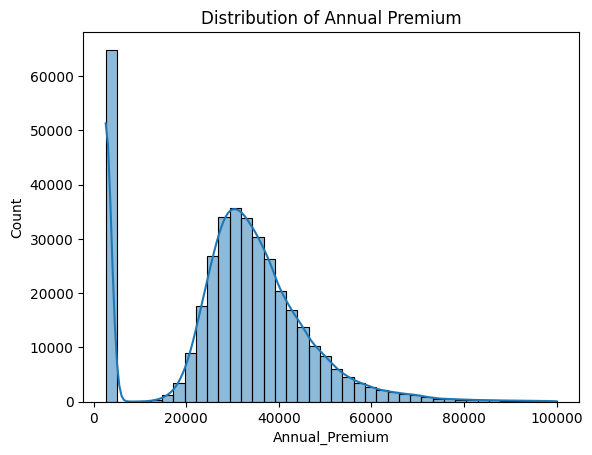

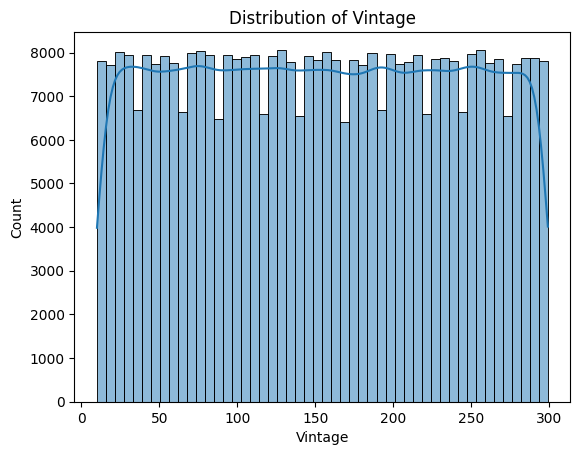

In [7]:
#  for Numerical colummns 
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Distribution of Age ')
plt.show()

sns.histplot(data[data['Annual_Premium'] < 100000] ['Annual_Premium'], bins=40, kde=True)
plt.title('Distribution of Annual Premium')
plt.show()

sns.histplot(data['Vintage'], bins=50, kde=True)
plt.title('Distribution of Vintage')
plt.show()



Interpretation:

Age Distibution:
- Age ranges roughly from 20 to 85 years.
- Distribution is right-skewed, meaning more customers are younger (20–35).
- A secondary peak around (35–50) suggests mid-aged customers also form a large share.

Annual Premium Distribution:
- Annual Premium is highly right-skewed.
- Most values lie between 20,000 – 50,000.

Vintage Distribution:
- Vintage is almost uniformly distributed between 0 and 300 days.
- Customers are evenly distributed in terms of how long they have been associated with the company.

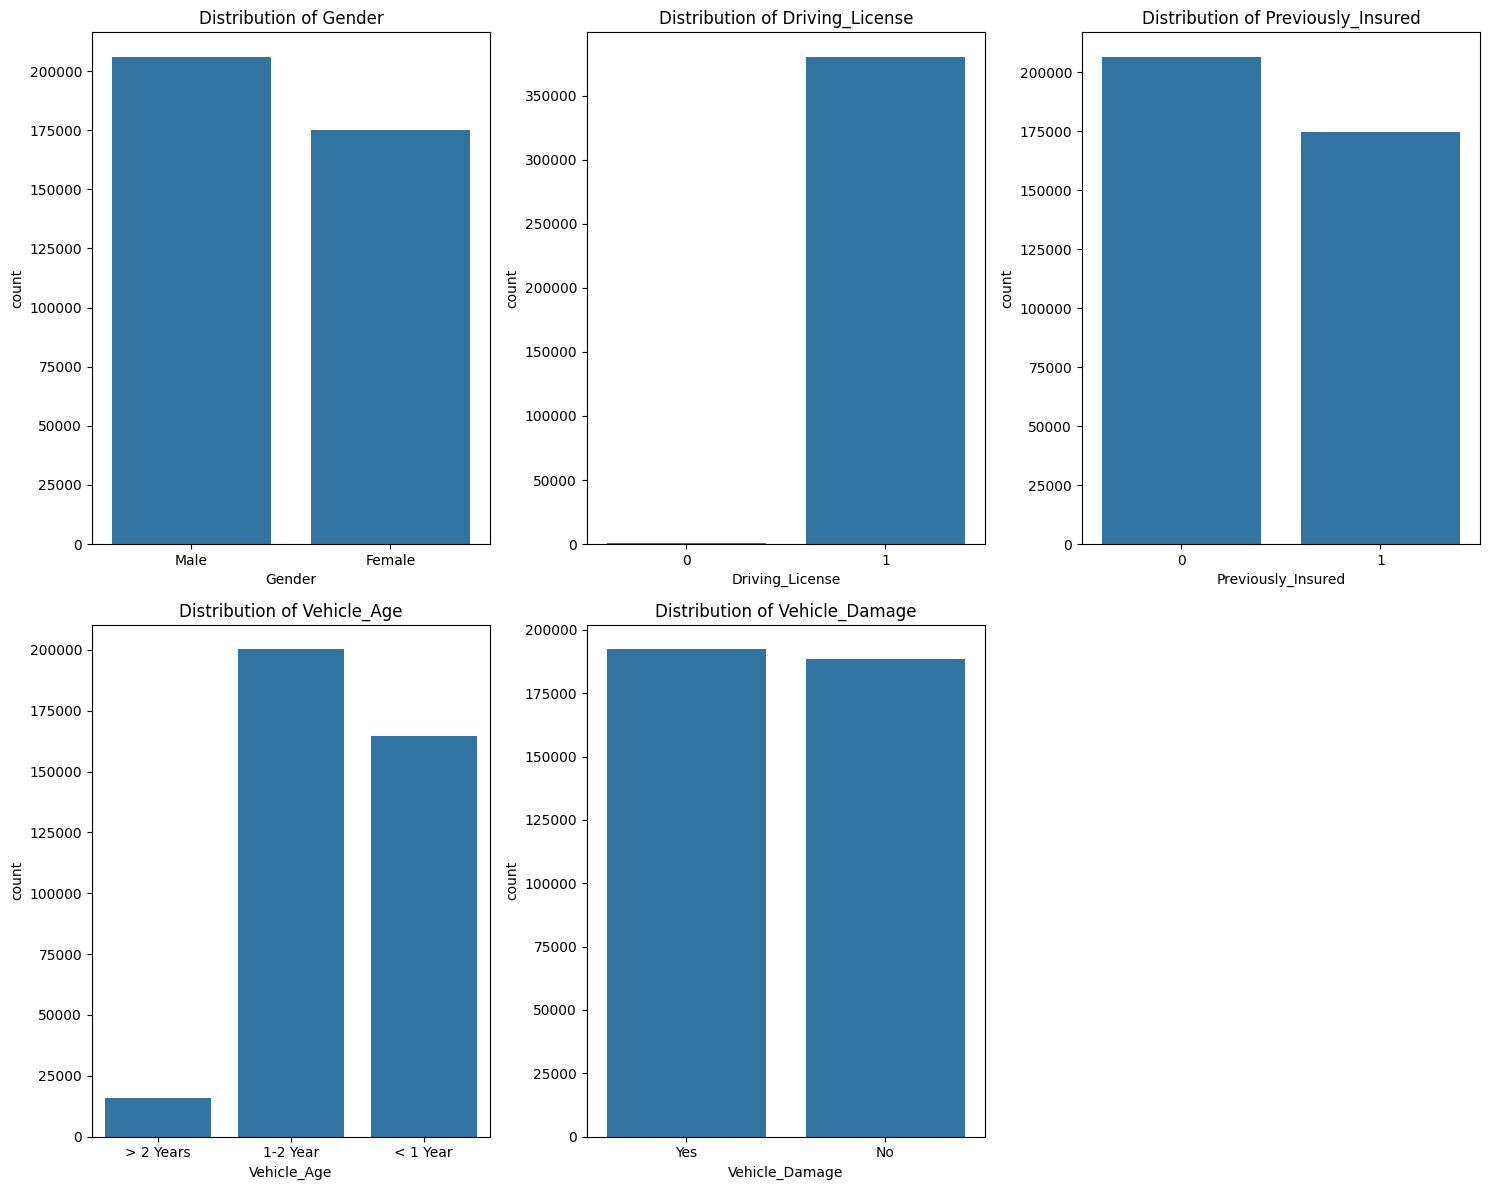

In [ ]:
# for Categorical columns  
categorical_cols = ['Gender', 'Driving_License', 'Previously_Insured', 
                    'Vehicle_Age', 'Vehicle_Damage']

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)  
    sns.countplot(x=data[col])
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Interpretation :
- There are <b>slightly more Male than Female</b> but it is almost balanced.
- Mostly customers have a <b>Driving licence = 1</b> . Therefore it may not be a highly informative and might contribute minimally to the model. 
- Number of customers that are <b>not insured previously are larger than those who are previously insured</b>. it can be highly predictive because customer who have previously insured shows less interest in new policy.
- Vehicle age varies but has clear category separation.Most vehicles fall in the 1–2 year category. The fewest vehicles are > 2 years old.<b>Customers with newer or older vehicles might behave differently regarding policy renewal.</b>

### Bivariate Analysis

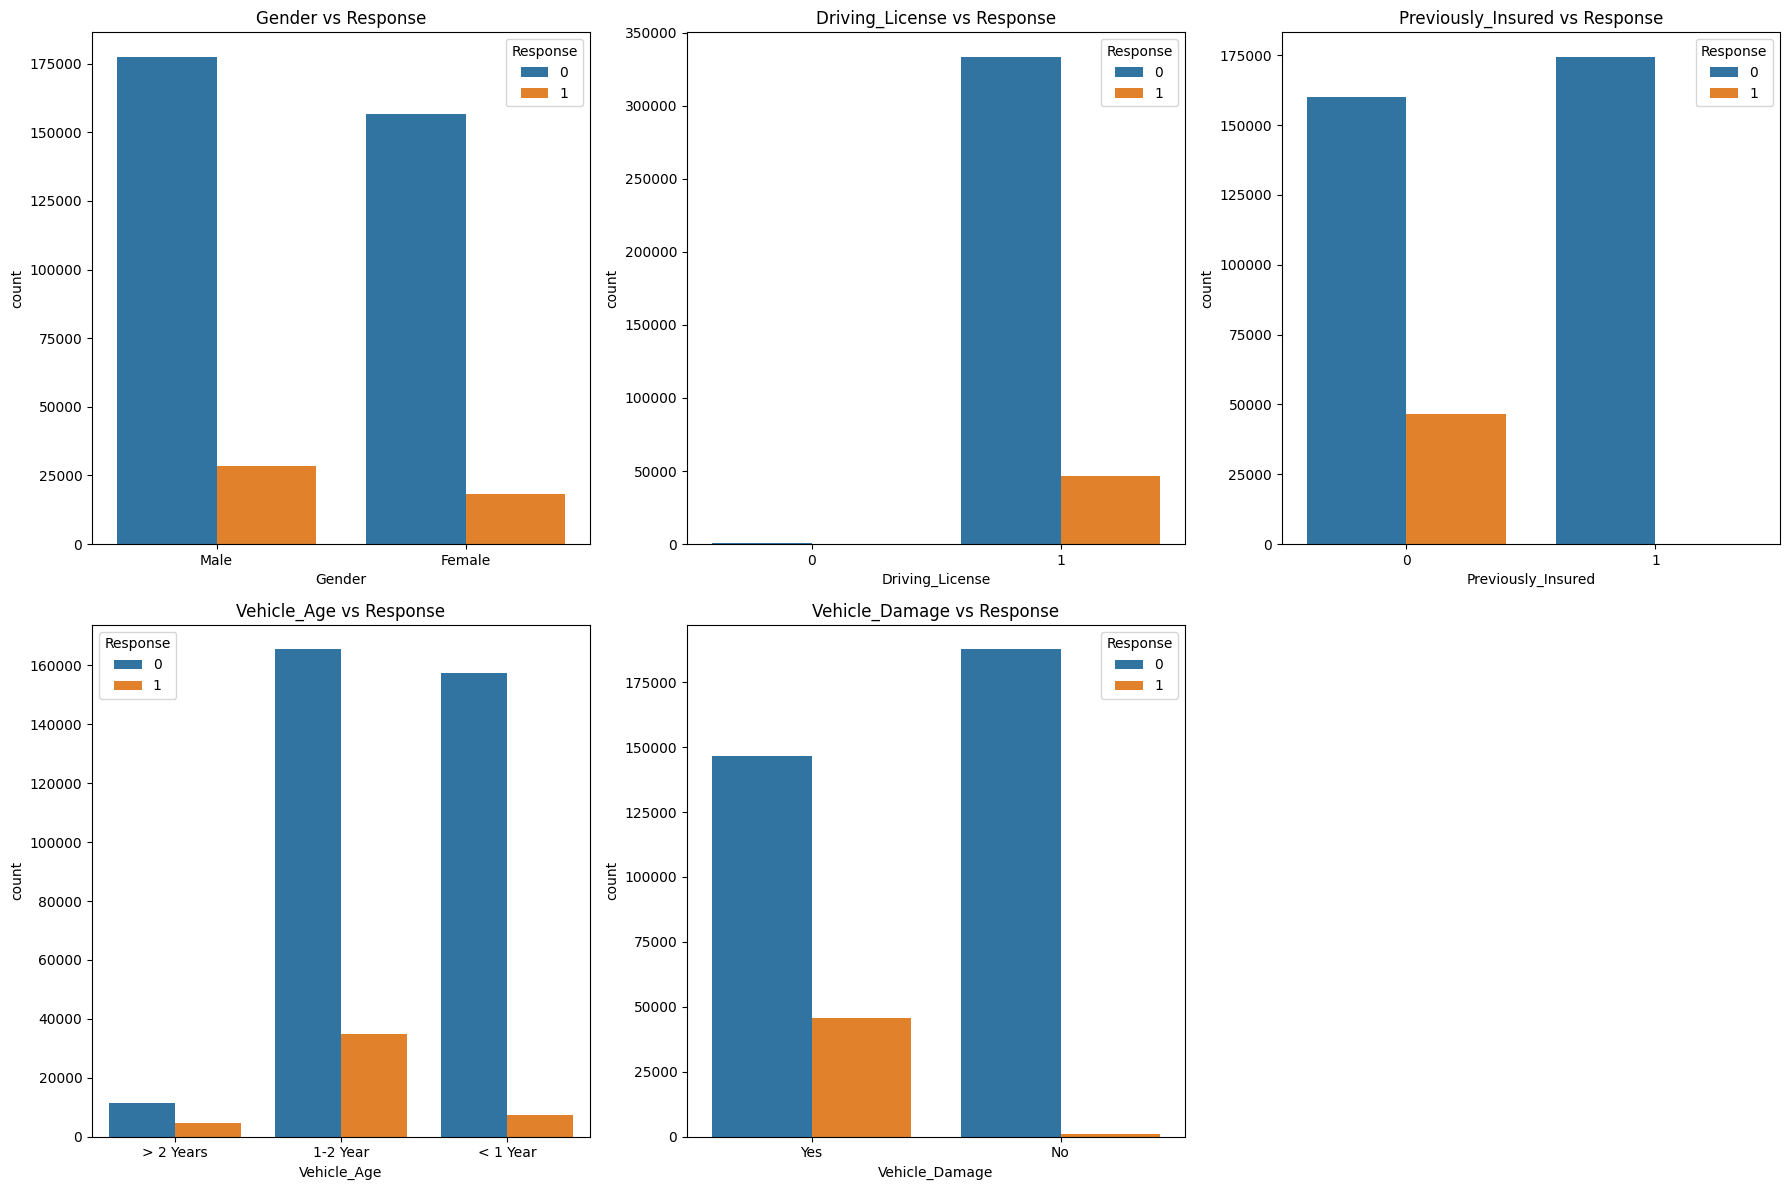

In [9]:
# for Categorical columns
cat_cols = ['Gender', 'Driving_License', 'Previously_Insured',
            'Vehicle_Age', 'Vehicle_Damage']

plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=data[col], hue=data['Response'])
    plt.title(f'{col} vs Response')
    plt.legend(title='Response')

plt.tight_layout()
plt.show()

Interpretation:

- Gender does not influence customer interest significantly.
- Due to lack of variability, Driving Licence is not helpful for prediction.
- Customers <b>not previously insured (0) show a very high response rate. Customers previously insured (1) almost never respond positively.</b>
- Customers with vehicle age customers with older vehicles <b>(> 2 years) show the highest interest</b> in buying insurance <b>followed by </b>vehicle age between <b>(1-2) years</b> and then <b>(<1) year shows the least response.</b>
- Customers with <b>Vehicle Damage = Yes respond much more than those with No</b>. This feature is very important and strongly influences the target.

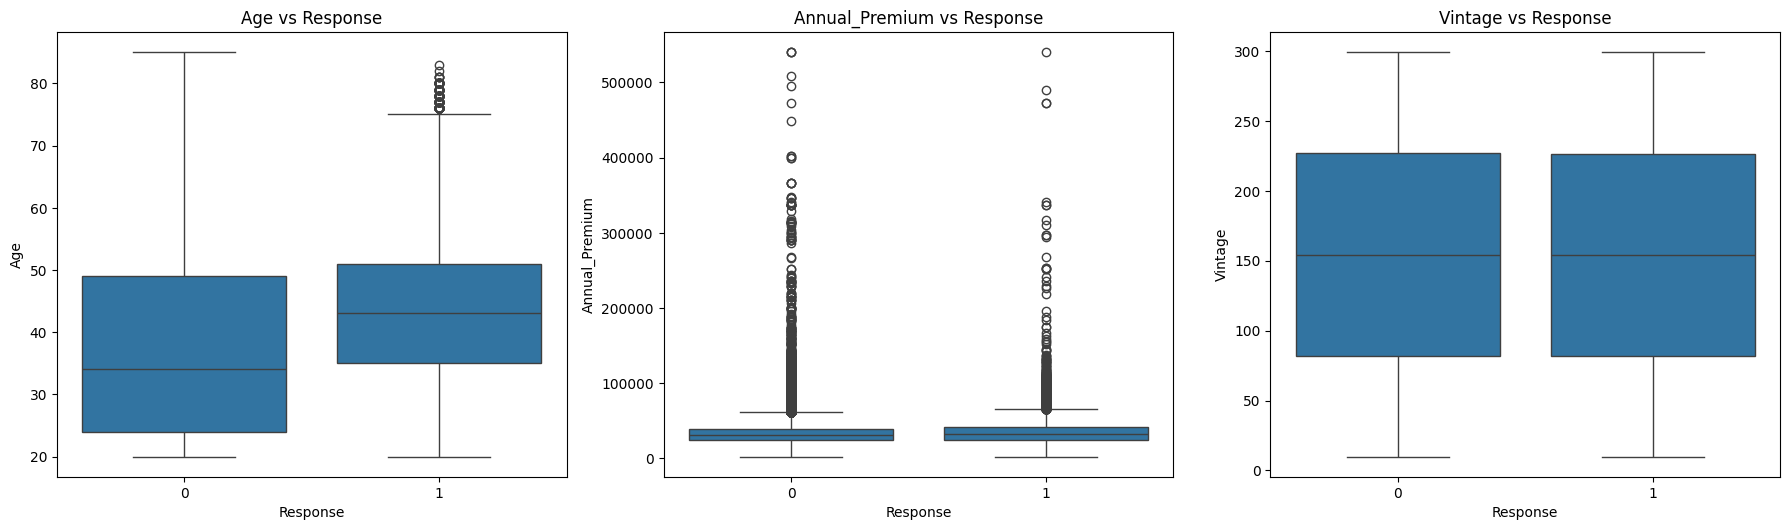

In [10]:
# for Numerical column
num_cols = ['Age', 'Annual_Premium', 'Vintage']

plt.figure(figsize=(18, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=data['Response'], y=data[col])
    plt.title(f'{col} vs Response')

plt.tight_layout()
plt.show()

Interpretation:

- Responders tend to be slightly older on average.
- Both responders and non-responders have similar premium distributions.Premium values do not strongly differentiate customers.
- Customer tenure does not affect response behavior.

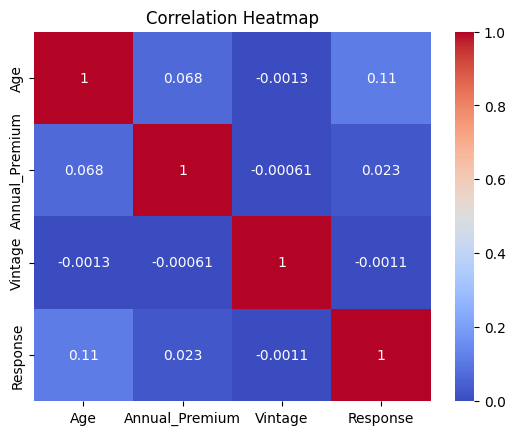

In [11]:
# correlation heatmap
numeric_cols = ['Age', 'Annual_Premium', 'Vintage', 'Response']
corr = data[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Interpretation:

- Age has a small positive correlation with Response (0.11)
- Premium has near-zero correlation (0.02)
- Vintage correlation is near zero
- No numeric feature strongly correlates with Response

### Data Preprocessing

In [14]:
# Drop id column
data_prep = data.drop(columns=['id'])

# Encode low-cardinality categorical columns
data_prep['Gender'] = data_prep['Gender'].map({'Male': 0, 'Female': 1})
data_prep['Vehicle_Age'] = data_prep['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
data_prep['Vehicle_Damage'] = data_prep['Vehicle_Damage'].map({'No': 0, 'Yes': 1})

data_prep.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28,0,2,1,40454,26,217,1
1,0,76,1,3,0,1,0,33536,26,183,0
2,0,47,1,28,0,2,1,38294,26,27,1
3,0,21,1,11,1,0,0,28619,152,203,0
4,1,29,1,41,1,0,0,27496,152,39,0


In [15]:
# Dividing independent and dependent features
X = data_prep.drop(columns=['Response'])
y = data_prep['Response']

# spliting into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
#  Standard scaling numerical columns 
num_cols = ['Age', 'Annual_Premium', 'Vintage']

scaler = StandardScaler()

# fitting only on train
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# transforming test set with same scaler
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [18]:
# saving the scaler encoder
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

## <b><u>Model Building</u></b> 

### Logistic Regression

In [ ]:
# Creating the logistic regression model
log_reg_model = LogisticRegression(
    class_weight='balanced',   
    max_iter=1000,
    C=1.0,                 
    penalty='l2',
    solver='lbfgs'
)

# Training the model
log_reg_model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# Predictions
y_pred_lr = log_reg_model.predict(X_test)
y_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluation metrics
lr_accuracy  = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression Results:")
print("Accuracy :", lr_accuracy)
print("Precision:", lr_precision)
print("Recall   :", lr_recall)
print("F1-Score :", lr_f1)
print("ROC-AUC  :", lr_auc)


Logistic Regression Results:
Accuracy : 0.6402219831544699
Precision: 0.25110811331663135
Recall   : 0.9763433954185399
F1-Score : 0.39947443337348076
ROC-AUC  : 0.8343454157998196


### Decision Tree

In [25]:
# creating the decision tree model 
dec_tree_model = DecisionTreeClassifier(
    class_weight='balanced',   
    max_depth=None,            
    random_state=42
)

# Train the model
dec_tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [27]:
# Predictions
y_pred_dt = dec_tree_model.predict(X_test)
y_proba_dt = dec_tree_model.predict_proba(X_test)[:, 1]

In [28]:
# Metrics
dt_accuracy  = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_proba_dt)

print("\nDecision Tree Results:")
print("Accuracy :", dt_accuracy)
print("Precision:", dt_precision)
print("Recall   :", dt_recall)
print("F1-Score :", dt_f1)
print("ROC-AUC  :", dt_auc)



Decision Tree Results:
Accuracy : 0.8300490671984466
Precision: 0.29369431117203565
Recall   : 0.275208734746307
F1-Score : 0.28415119363395225
ROC-AUC  : 0.5913822348446436


### Random Forest Classifier

In [30]:
# creating the random forest model 
rand_for_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train the model
rand_for_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
# Predictions
y_pred_rf = rand_for_model.predict(X_test)
y_proba_rf = rand_for_model.predict_proba(X_test)[:, 1]

In [33]:
# Metrics
rf_accuracy  = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf)

print("\nRandom Forest Results:")
print("Accuracy :", rf_accuracy)
print("Precision:", rf_precision)
print("Recall   :", rf_recall)
print("F1-Score :", rf_f1)
print("ROC-AUC  :", rf_auc)


Random Forest Results:
Accuracy : 0.8686599669386791
Precision: 0.368874950999608
Recall   : 0.10072789552558338
F1-Score : 0.15824434541326832
ROC-AUC  : 0.8351301125416011


In [ ]:
# comparion table for the models
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision],
    'Recall': [lr_recall, dt_recall, rf_recall],
    'F1-Score': [lr_f1, dt_f1, rf_f1],
    'ROC-AUC': [lr_auc, dt_auc, rf_auc]
})

comparison_df


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.640222,0.251108,0.976343,0.399474,0.834345
1,Decision Tree,0.830049,0.293694,0.275209,0.284151,0.591382
2,Random Forest,0.868660,0.368875,0.100728,0.158244,0.835130


Interpretation:

- Logistic regression and Random forest can be the best choices for final model.

In [ ]:
# Cross Validation for LR and RF - we are doing this to test stability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
lr_cv_scores = cross_val_score(log_reg_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print("LR CV ROC-AUC:", lr_cv_scores.mean())

# Random Forest CV
rf_cv_scores = cross_val_score(rand_for_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print("RF CV ROC-AUC:", rf_cv_scores.mean())

LR CV ROC-AUC: 0.83154985297897
RF CV ROC-AUC: 0.836601430464133


Interpretation:
- Both models are very stable.
- Random Forest generalizes slightly better than Logistic Regression.

### Hyperparameter Tuning for Random Forest

In [ ]:
# hypertuned tuned Random Forest
best_rf = RandomForestClassifier(
    n_estimators=300,        
    max_depth=20,            
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train
best_rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
# Predict
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

# Evaluate
print("TUNED RF (Manual) Accuracy :", accuracy_score(y_test, y_pred_best))
print("TUNED RF (Manual) Precision:", precision_score(y_test, y_pred_best))
print("TUNED RF (Manual) Recall   :", recall_score(y_test, y_pred_best))
print("TUNED RF (Manual) F1       :", f1_score(y_test, y_pred_best))
print("TUNED RF (Manual) ROC-AUC  :", roc_auc_score(y_test, y_proba_best))

TUNED RF (Manual) Accuracy : 0.7592296187452442
TUNED RF (Manual) Precision: 0.3118054975352995
TUNED RF (Manual) Recall   : 0.7989723827874117
TUNED RF (Manual) F1       : 0.4485576923076923
TUNED RF (Manual) ROC-AUC  : 0.8512594716176058


In [50]:
thresholds = np.arange(0.10, 0.51, 0.05)

print("Threshold| Recall| Precision| F1-score")
for t in thresholds:
    y_pred_thresh = (y_proba_best >= t).astype(int)
    r  = recall_score(y_test, y_pred_thresh)
    p  = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"{t:.2f}     | {r:.4f} | {p:.4f} | {f1:.4f}")

Threshold| Recall| Precision| F1-score
0.10     | 0.9841 | 0.2452 | 0.3926
0.15     | 0.9766 | 0.2544 | 0.4037
0.20     | 0.9675 | 0.2617 | 0.4120
0.25     | 0.9528 | 0.2686 | 0.4191
0.30     | 0.9305 | 0.2757 | 0.4254
0.35     | 0.9062 | 0.2847 | 0.4333
0.40     | 0.8763 | 0.2938 | 0.4400
0.45     | 0.8392 | 0.3025 | 0.4447
0.50     | 0.7990 | 0.3118 | 0.4486


Final Model: Tuned Random Forest
- Hyperparameters:
- n_estimators = 300
- max_depth = 20
- min_samples_split = 5
- min_samples_leaf = 2
- class_weight = 'balanced'

Final Threshold: 0.20

In [51]:
# saving tuned random forest model
with open("tuned_random_forest.pkl", "wb") as file:
    pickle.dump(best_rf, file)

In [52]:
# Saving the chosen threshold
best_threshold = 0.20
with open("best_threshold.pkl", "wb") as file:
    pickle.dump(best_threshold, file)